<h1> Discrete Cosine Transform </h1>

In [34]:
# import python modules
import scipy.fft
import numpy as np
import matplotlib.pyplot as plt

Figure 3.14

Define DCT Coefficients

In [27]:
def dct_coeff():
    coeff = np.zeros((64, 64))

    for k in range(8):
        for l in range(8):
            entry = np.zeros((8, 8))
            for m in range(8):
                for n in range(8):
                    entry[m, n] = np.cos((n + 0.5)*l*np.pi/8) * np.cos((m + 0.5)*k*np.pi/8)
                    coeff[(k*8)+m, (l*8)+n] = entry[m, n]
    
    # Normalization to grayscale numbers [0,255]
    coeff = coeff * 0.5 + np.ones((64, 64)) * 0.5
    coeff = coeff * 255
    
    return coeff

In [28]:
coeff = dct_coeff()

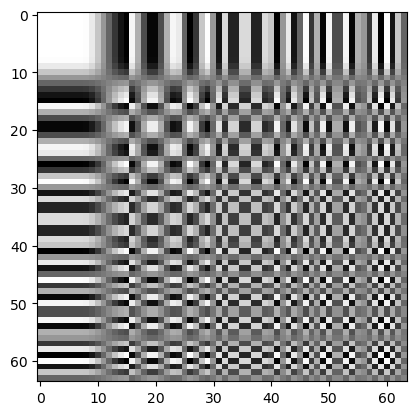

In [29]:
plt.imshow(coeff, cmap=plt.cm.gray)
plt.show()

Extract and plot coefficients.

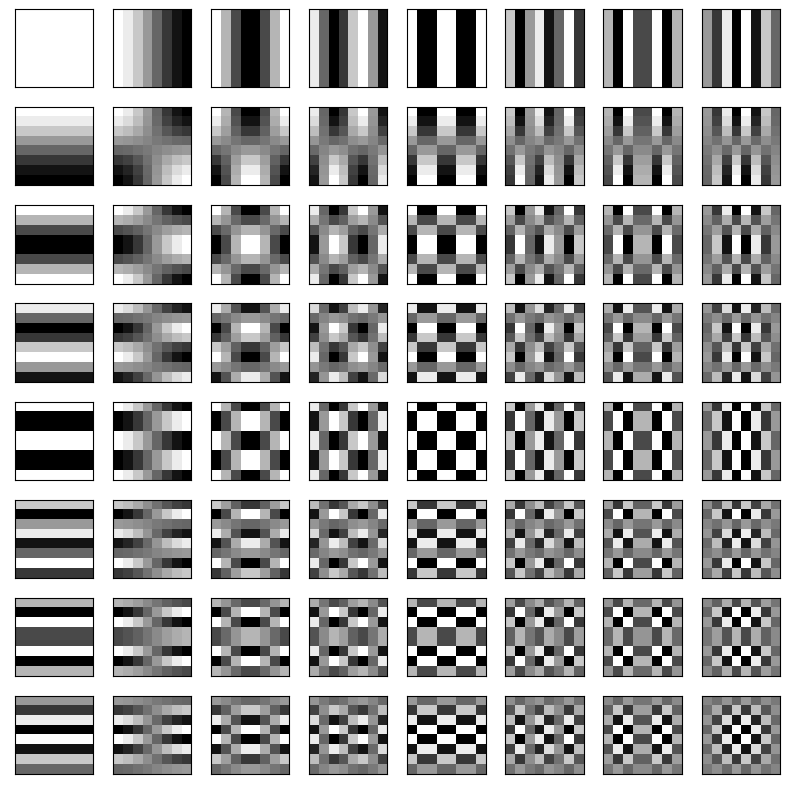

In [7]:
plt.close('all')

fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(8, 8))

for k in range(8):
    for l in range(8):
        axes[k, l].imshow(coeff[8*k:8*(k+1), 8*l:8*(l+1)], cmap=plt.cm.gray)
        axes[k, l].get_xaxis().set_visible(False)
        axes[k, l].get_yaxis().set_visible(False)
        # axes[k, l].set_title(f"{(k, l)}")

axes[0, 0].imshow(coeff[0:8, 0:8], cmap=plt.cm.gray_r) 
        
plt.tight_layout()
plt.savefig(fname = "dct_coeff", dpi=500)
plt.show()


Create some coefficients as 3d plot.

In [30]:
x = np.linspace(0, 8, 100)
x, y = np.meshgrid(x, x)


dct_repr00 = np.ones((100, 100))
dct_repr01 = np.cos((x + 0.5)*np.pi/8)
dct_repr70 = np.cos((y + 0.5)*np.pi*7/8)
dct_repr44 = np.cos((x + 0.5)*0.5*np.pi) * np.cos((y + 0.5)*0.5*np.pi)


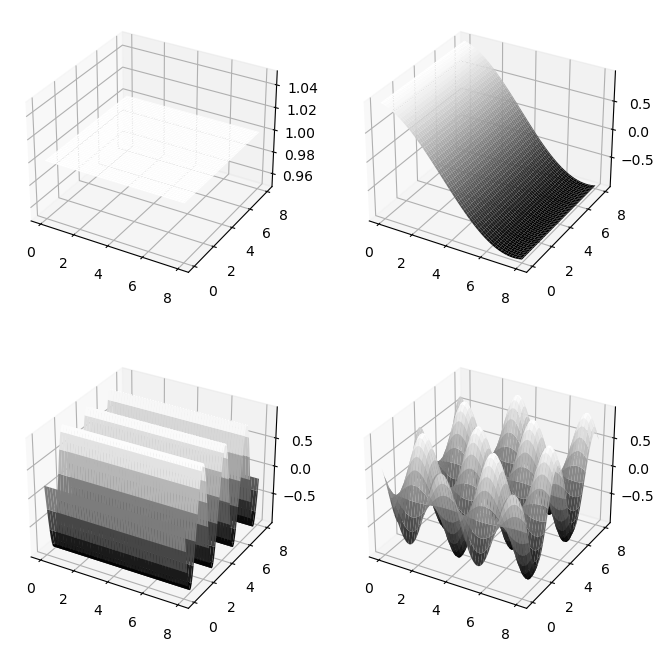

In [31]:
plt.close('all')

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.plot_surface(x, y, dct_repr00, cmap=plt.cm.gray_r)

ax = fig.add_subplot(2, 2, 2, projection='3d')
ax.plot_surface(x, y, dct_repr01, cmap=plt.cm.gray)

ax = fig.add_subplot(2, 2, 3, projection='3d')
ax.plot_surface(x, y, dct_repr70, cmap=plt.cm.gray)

ax = fig.add_subplot(2, 2, 4, projection='3d')
ax.plot_surface(x, y, dct_repr44, cmap=plt.cm.gray)


plt.savefig(fname = "dct_coeff3d", dpi=500)
plt.show()


<h2> Apply JPEG Compression with the DCT to an image </h2>

In [10]:
from skimage.data import camera
image = camera()

Apply DCT to image.

[[ 1.35329980e+08 -2.59590427e+07  2.15278076e+05 ... -2.49799419e+03
   1.88014517e+04 -4.09654863e+04]
 [ 2.04372701e+07  6.88858800e+06  9.58665970e+06 ... -2.20397317e+04
  -9.12897934e+03  3.84504657e+04]
 [ 1.96882451e+07  7.64620732e+06 -3.79026969e+06 ...  2.33713028e+04
   1.16138510e+04 -4.51296715e+04]
 ...
 [-2.25887016e+04  1.27882189e+04 -8.78516302e+03 ...  3.65038619e+03
  -3.59807871e+03 -1.14488017e+03]
 [ 3.84226947e+04 -2.04862151e+04 -3.40199462e+03 ...  1.38282200e+03
   7.52638479e+03 -2.85886022e+03]
 [ 3.68103293e+04 -2.66780843e+04  1.61514437e+04 ...  4.22565790e+03
  -5.00704535e+03 -2.14018072e+03]]


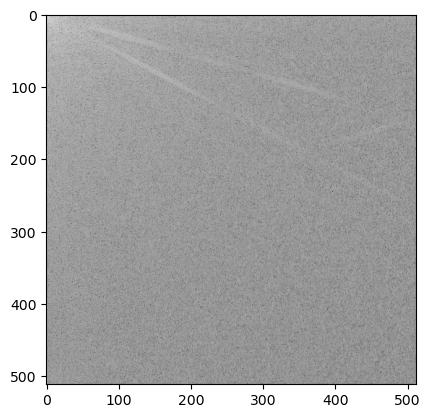

In [20]:
dct_image = scipy.fft.dctn(image)
print(dct_image)
#display dct (log grayscale)
plt.imshow(np.log(1e-7 + abs(dct_image)), cmap=plt.cm.gray)
plt.show()

The DCT shows dominance of upper left components.

Define DCT for application on smaller patches.

In [13]:
def local_dct(I, w = 8) :  # w = patch size
    lI = np.zeros(I.shape)
    # Loop over the small (w,w) patches
    for i in range(1,I.shape[0]//w+1):
        for j in range(1,I.shape[1]//w+1):
            lI[(i-1)*w: i*w, (j-1)*w: j*w] = scipy.fft.dctn(I[(i-1)*w: i*w, (j-1)*w: j*w])
    return lI


def ilocal_dct(lI, w = 8) :  # w = patch size
    I = np.zeros(lI.shape)
    # Loop over the small (w,w) patches
    for i in range(1,I.shape[0]//w+1):
        for j in range(1,I.shape[1]//w+1):
            I[(i-1)*w: i*w, (j-1)*w: j*w] = scipy.fft.idctn(lI[(i-1)*w: i*w, (j-1)*w: j*w])
    return I

Figure 3.15

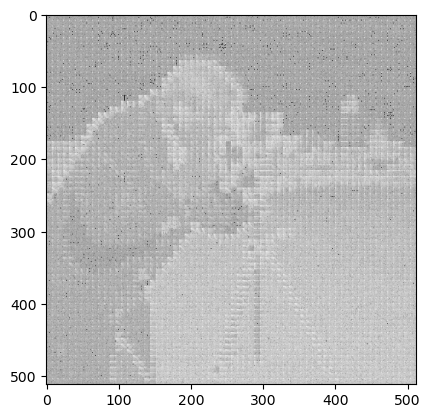

In [22]:
lI = local_dct(image, w = 8)
plt.imshow(np.log(1e-7 + abs(lI)), cmap=plt.cm.gray)
plt.savefig('patches_dct')
plt.show()


Define thresholding for local DCT.

In [32]:
def lDCT_threshold(lI, threshold) :
    lI_thresh = lI.copy()                  # Create a copy of the local DCT transform
    lI_thresh[ abs(lI) < threshold ] = 0   # Remove all the small coefficients
    I_thresh = ilocal_dct(lI_thresh)       # Invert the new transform...

    return I_thresh

Figure 3.16

Set cutoff to maintain only a part of the frequencies.

[    0.     0.     0. ... 60976. 62352. 62552.]


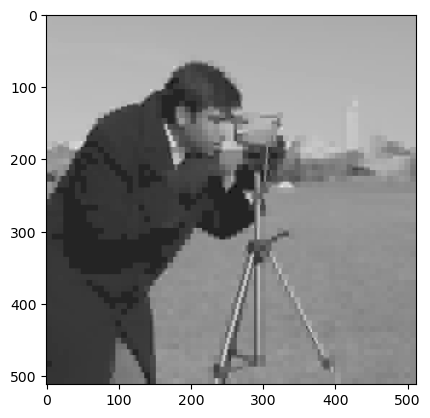

In [33]:
Abs_values = np.sort( abs(lI.ravel()) )  # Sort the coefficients' magnitudes
print(Abs_values)                        # in ascending order...

cutoff = Abs_values[-4096]               # And select the 4000th largest value
JPEG = lDCT_threshold(lI, cutoff)        # as a cutoff
plt.imshow(JPEG, cmap=plt.cm.gray)
plt.savefig('after_jpeg')
plt.show()